Task: To Build and enhance a robust real world Question Answering system.
Goal: Design a system that can *thoughtfully handle ambiguity* and *avoid common failures* through RAG and Finetuning.

Core features:
1. MULTIPLE SOURCES RAG: Retrieves information from two distinct and deliberately overlapping sources, prioritizes them, and cites its evidence
2. Finetuning the guardrail model: Determines if a question is answerable from the retrieved context in order to reduce model hallucination.


Source A (corpus): filtered_wikiqa.tsv
Source B (Source of Truth): Tables 1, 2, 3, and 4 [https://aclanthology.org/D15-1237.pdf](https://aclanthology.org/D15-1237.pdf)

Model used: `google/flan-t5-small`

## Tasks

### 1. Multi-Source RAG with Prioritization and Citation

**Goal:** Design a RAG system that can handle queries over two different sources and justify its answers.

*   **Data Ingestion:**
    *   Load the attached `filtered_wikiqa.tsv` corpus.
    *   Extract the content of all four tables (Tables 1-4) from the provided PDF.
*   **System Design:**
    *   Create a retrieval system that indexes all documents from both sources, while keeping the citation
    *   Implement a **prioritization logic** for retrieval.
    *   The final output for a question must include two things: the generated answer string and **a citation** indicating which document(s) and source(s) were used to generate it.


### 2. Finetuning for Answerability (Guardrail Model)

**Goal:** Finetune `flan-t5-small` to function as a post-retrieval check, preventing the system from answering questions when the retrieved context is irrelevant.

*   **Problem Formulation:**
    *   Build a model that takes a `question` and a `context` (the retrieved documents) and outputs one of two classifications: **`ANSWERABLE`** or **`UNANSWERABLE`**.
*   **Data Creation:**
    *   Create a small dataset (15-20 examples is sufficient) to finetune the model for this binary classification task. The dataset should contain *Positive examples (`ANSWERABLE`)* and *Negative examples (`UNANSWERABLE`)*
    *   Devise and **document** a strategy to create these.
*   **Finetuning & Demonstration:**
    *   Finetune `flan-t5-small` on the created dataset.
    *   Demonstrate the trained model on at least two examples: one where the provided context is relevant (and it outputs `ANSWERABLE`), and one where it is not (and it outputs `UNANSWERABLE`).



# Workflow:
Clean data, data prep -> chunking -> embed data for RAG-> Context ranking -> Guardrail Check -> Generation + Citation

# Considerations:
Do not use other vendor models or online models

Step 0: Load Dependencies

In [38]:
# !pip install jpype1
# !apt-get install -y default-jre

Step 1: Load the corpus

In [39]:
import pandas as pd
import numpy as np
import torch

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Multi_source_RAG/wikiqa_sample.tsv', sep='\t')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# Explore the data
print("Dataset shape:", df.shape)
print("Column names:")
print(df.columns.tolist())
print("First few rows:")
print(df.head(10))

Dataset shape: (446, 7)
Column names:
['QuestionID', 'Question', 'DocumentID', 'DocumentTitle', 'SentenceID', 'Sentence', 'Label']
First few rows:
  QuestionID                                        Question DocumentID  \
0         Q7  how a beretta model 21 pistols magazines works         D7   
1         Q7  how a beretta model 21 pistols magazines works         D7   
2         Q7  how a beretta model 21 pistols magazines works         D7   
3       Q295        how many apple store are there in total?       D294   
4       Q295        how many apple store are there in total?       D294   
5       Q295        how many apple store are there in total?       D294   
6       Q295        how many apple store are there in total?       D294   
7       Q295        how many apple store are there in total?       D294   
8       Q366              how does lsd impact the human body       D365   
9       Q366              how does lsd impact the human body       D365   

                DocumentTit

In [41]:
# Check data types
print("Data types:")
print(df.dtypes)

# Expected data fields (https://huggingface.co/datasets/microsoft/wiki_qa)
# question_id: a string feature.
# question: a string feature.
# document_title: a string feature.
# answer: a string feature.
# label: a classification label, with possible values including 0 (0), 1 (1).

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check unique counts
print(f"Number of unique questions: {df['Question'].nunique()}")
print(f"Number of unique documents: {df['DocumentID'].nunique()}")
print(f"Number of unique labels: {df['Label'].nunique()}")

# Check Label distribution
if 'Label' in df.columns:
    print("\nLabel distribution:")
    print(df['Label'].value_counts())
    print(f"Positive examples (Label=1): {(df['Label']==1).sum()}")
    print(f"Negative examples (Label=0): {(df['Label']==0).sum()}")

print("First Question with Correct Answer")
if 'Label' in df.columns:
    sample = df[df['Label'] == 1].iloc[0]
    print(f"Question: {sample['Question']}")
    print(f"Document Title: {sample['DocumentTitle']}")
    print(f"Answer Sentence: {sample['Sentence']}")

Data types:
QuestionID       object
Question         object
DocumentID       object
DocumentTitle    object
SentenceID       object
Sentence         object
Label             int64
dtype: object
Missing values per column:
QuestionID       0
Question         0
DocumentID       0
DocumentTitle    0
SentenceID       0
Sentence         0
Label            0
dtype: int64
Number of unique questions: 40
Number of unique documents: 40
Number of unique labels: 2

Label distribution:
Label
0    415
1     31
Name: count, dtype: int64
Positive examples (Label=1): 31
Negative examples (Label=0): 415
First Question with Correct Answer
Question: how many apple store are there in total?
Document Title: Apple Store
Answer Sentence: , Apple has 405 stores worldwide, with global sales of billion in merchandise in 2011, and they lead the United States retail market in terms of sales per unit area .


We do EDA here to figure out if there is any missing data that needs fixing through mean or median for numerical data. For NLP text, could filter out any missing rows since its not feasible to mean or median text.

For the wikiQA dataset, a label of 1 means that the answer answers the question. It is also verified that there are 2 unique labels in the dataset so we can directly use this data for POSITIVE and NEGATIVE training.

In [42]:

# Sentences per question
sentences_per_q = df.groupby('Question').size()
print(f"Average candidate sentences per question: {sentences_per_q.mean():.2f}")

# Get the success rate. If there is no correct answer to the question, the guardrail should say that it is NOT UNANSWERABLE
success_rate = df.groupby('Question')['Label'].apply(lambda x: (x == 1).any())
print(f"Questions with at least one correct answer: {success_rate.sum()}/{len(success_rate)}")


# Sample qns
print("\nSample Qns")
unique_questions = df['Question'].unique()[:5]
for i, q in enumerate(unique_questions, 1):
    print(f"{i}. {q}")

Average candidate sentences per question: 11.15
Questions with at least one correct answer: 20/40

Sample Qns
1. how a beretta model 21 pistols magazines works
2. how many apple store are there in total?
3. how does lsd impact the human body
4. how many muscles in the human body
5. how much total wealth in USA


# Getting Tables 1-4 from the PDF (Source of Truth)

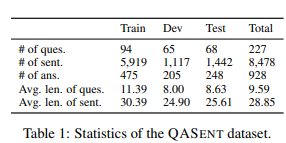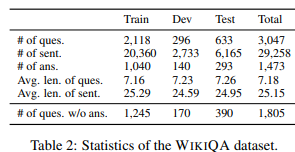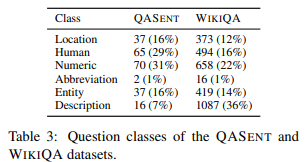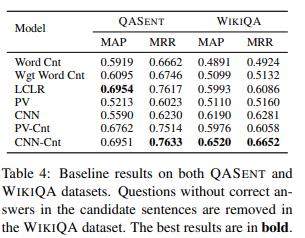


Take note that in Table 4, questions with no candidate answers are removed in the WikiQA Dataset

In [43]:
import tabula
import os

pdf_path = '/content/drive/MyDrive/Multi_source_RAG/D15-1237.pdf'
save_dir = '/content/drive/MyDrive/Multi_source_RAG/models'
os.makedirs(save_dir, exist_ok=True)


In [44]:
automated_tables = tabula.read_pdf(
    pdf_path,
    pages='all',
    multiple_tables=True,
    stream=True,
    guess=True
)

valid_tables = [t for t in automated_tables if t.shape[0] > 2 and t.shape[1] > 1]

print(f"   Extracted {len(valid_tables)} tables")

if len(valid_tables) > 0:
    print(f"   Successfully extracted {len(valid_tables)} tables automatically")
    for i, t in enumerate(valid_tables):
        print(f"      Table {i+1}: Shape {t.shape}")




   Extracted 2 tables
   Successfully extracted 2 tables automatically
      Table 1: Shape (16, 9)
      Table 2: Shape (10, 7)


Attempted to automatically pull the tables from the pdf but only with limited success. Have found some promising paid tools like Azure Intelligence if we want to use this for prod. Given the small scope of 4 tables, it would be more efficient to key in manually.


In [45]:


# Table 1: Statistics of the QASENT dataset
table1 = {
    'table_id': 'Table1',
    'title': 'Statistics of the QASENT dataset',
    'content': """
QASENT Dataset Statistics:
- Train: 94 questions, 5,919 sentences, 475 answers
- Dev: 65 questions, 1,117 sentences, 205 answers
- Test: 68 questions, 1,442 sentences, 248 answers
- Total: 227 questions, 8,478 sentences, 928 answers
- Average length of questions: 11.39 words (train), 8.00 words (dev), 8.63 words (test), 9.59 words (total)
- Average length of sentences: 30.39 words (train), 24.90 words (dev), 25.61 words (test), 28.85 words (total)
""",
    'metadata': {
        'page': 3,
        'type': 'dataset_statistics',
        'contains_keywords': ['QASENT', 'questions', 'sentences', 'answers', 'dataset', 'statistics', 'train', 'test', 'dev', 'average length']
    }
}

# Table 2: Statistics of the WikiQA dataset
table2 = {
    'table_id': 'Table2',
    'title': 'Statistics of the WikiQA dataset',
    'content': """
WikiQA Dataset Statistics:
- Train: 2,118 questions, 20,360 sentences, 1,040 answers
- Dev: 296 questions, 2,733 sentences, 140 answers
- Test: 633 questions, 6,165 sentences, 293 answers
- Total: 3,047 questions, 29,258 sentences, 1,473 answers
- Average length of questions: 7.16 words (train), 7.23 words (dev), 7.26 words (test), 7.18 words (total)
- Average length of sentences: 25.29 words (train), 24.59 words (dev), 24.95 words (test), 25.15 words (total)
- Questions without answers: 1,345 (train), 170 (dev), 390 (test), 1,805 total
""",
    'metadata': {
        'page': 3,
        'type': 'dataset_statistics',
        'contains_keywords': ['WikiQA', 'questions', 'sentences', 'answers', 'dataset', 'statistics', 'train', 'test', 'dev', 'without answers']
    }
}

# Table 3: Question classes of the QASENT and WikiQA dataset
table3 = {
    'table_id': 'Table3',
    'title': 'Question classes of the QASENT and WikiQA dataset',
    'content': """
Question Class Distribution:

QASENT dataset:
- Location: 37 questions (16%)
- Human: 65 questions (29%)
- Numeric: 70 questions (31%)
- Abbreviation: 2 questions (1%)
- Entity: 37 questions (16%)
- Description: 16 questions (7%)

WikiQA dataset:
- Location: 373 questions (12%)
- Human: 494 questions (16%)
- Numeric: 658 questions (22%)
- Abbreviation: 16 questions (1%)
- Entity: 419 questions (14%)
- Description: 1087 questions (36%)
""",
    'metadata': {
        'page': 4,
        'type': 'question_distribution',
        'contains_keywords': ['question class', 'question classes', 'location', 'human', 'numeric', 'abbreviation', 'entity', 'description', 'distribution', 'QASENT', 'WikiQA']
    }
}

# Table 4: Baseline results on both QASENT and WikiQA
table4 = {
    'table_id': 'Table4',
    'title': 'Baseline results on both QASENT and WikiQA (questions with no answers removed in WikiQA)',
    'content': """
Baseline Model Performance (MAP and MRR scores):
Note: Questions with no candidate answers are removed in the WikiQA dataset. The best results are in bold.
Models: Word Cnt, Wgt Word Cnt, LCLR, PV, CNN, PV+Cnt, CNN+Cnt


QASENT dataset results:
- Word Cnt: MAP 0.5919, MRR 0.6662
- Wgt Word Cnt: MAP 0.6095, MRR 0.6746
- LCLR: MAP 0.6954, MRR 0.7617
- PV: MAP 0.5213, MRR 0.6023
- CNN: MAP 0.5590, MRR 0.6230
- PV+Cnt: MAP 0.6762, MRR 0.7514
- CNN+Cnt: MAP 0.6951, MRR 0.7633 (best MRR for QASENT)

WikiQA dataset results:
- Word Cnt: MAP 0.4891, MRR 0.4924
- Wgt Word Cnt: MAP 0.5099, MRR 0.5132
- LCLR: MAP 0.5993, MRR 0.6086
- PV: MAP 0.5110, MRR 0.5160
- CNN: MAP 0.6190, MRR 0.6281
- PV+Cnt: MAP 0.5976, MRR 0.6058
- CNN+Cnt: MAP 0.6520, MRR 0.6652 (best results for WikiQA)

Metrics:
- MAP = Mean Average Precision
- MRR = Mean Reciprocal Rank
Higher scores indicate better model performance.
""",
    'metadata': {
        'page': 4,
        'type': 'model_performance',
        'contains_keywords': ['baseline', 'model', 'performance', 'results', 'MAP', 'MRR', 'accuracy', 'CNN', 'LCLR', 'Word Cnt', 'best', 'scores', 'experiment']
    }
}



tables = [table1, table2, table3, table4]

# Verify extraction
for i, table in enumerate(tables, 1):
    print(f"{i}. {table['table_id']}: {table['title']}")
    print(f"Type: {table['metadata']['type']}")
    print(f"Key terms: {', '.join(table['metadata']['contains_keywords'][:6])}...")

print("table4",table4)

1. Table1: Statistics of the QASENT dataset
Type: dataset_statistics
Key terms: QASENT, questions, sentences, answers, dataset, statistics...
2. Table2: Statistics of the WikiQA dataset
Type: dataset_statistics
Key terms: WikiQA, questions, sentences, answers, dataset, statistics...
3. Table3: Question classes of the QASENT and WikiQA dataset
Type: question_distribution
Key terms: question class, question classes, location, human, numeric, abbreviation...
4. Table4: Baseline results on both QASENT and WikiQA (questions with no answers removed in WikiQA)
Type: model_performance
Key terms: baseline, model, performance, results, MAP, MRR...
table4 {'table_id': 'Table4', 'title': 'Baseline results on both QASENT and WikiQA (questions with no answers removed in WikiQA)', 'content': '\nBaseline Model Performance (MAP and MRR scores):\nNote: Questions with no candidate answers are removed in the WikiQA dataset. The best results are in bold.\nModels: Word Cnt, Wgt Word Cnt, LCLR, PV, CNN, PV+C

Determine the max tokens for the model to avoid overflowing the context window later when combining question + k context

In [46]:
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained("google/flan-t5-small")
print(tok.model_max_length, "max tokens")

512 max tokens


In [47]:
# PDF table chunking
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained("google/flan-t5-small")

def pack_lines_to_token_chunks(lines, chunk_tok_limit, overlap_lines=1):
    """
    Pack lines into chunks under a token limit.
    Overlap by a few lines to keep context continuity.
    """
    chunks = []
    cur = []
    cur_tokens = 0

    for line in lines:
        line = line.strip()
        if not line:
            continue
        t = len(tok(line, add_special_tokens=False).input_ids)
        # if adding this line would exceed the limit, flush current chunk
        if cur and cur_tokens + t > chunk_tok_limit:
            chunks.append("\n".join(cur))
            # start next chunk with an overlap of last few lines
            cur = cur[-overlap_lines:] if overlap_lines > 0 else []
            cur_tokens = len(tok("\n".join(cur), add_special_tokens=False).input_ids) if cur else 0
        # add line
        cur.append(line)
        cur_tokens += t

    if cur:
        chunks.append("\n".join(cur))
    return chunks

def table_to_docs(table, chunk_tok_limit=180, overlap_lines=1): #guesstimate the amount of tokens for the source
    """
    Convert one table dict to multiple chunk docs.
    """
    # split table content by lines/bullets
    raw = (table["content"] or "").strip()
    # normalize whitespace and split on newlines
    lines = [ln for ln in raw.splitlines() if ln.strip()]

    # pack lines into token-bounded chunks
    chunks = pack_lines_to_token_chunks(
        lines,
        chunk_tok_limit=chunk_tok_limit,
        overlap_lines=overlap_lines
    )

    docs = []
    for i, chunk in enumerate(chunks, 1):
        docs.append({
            "text": chunk,
            "source": "PDF",
            "doc_id": f'{table["table_id"]}#c{i}',
            "metadata": {
                "parent_table_id": table["table_id"],
                "title": table["title"],
                "page": table["metadata"]["page"],
                "type": table["metadata"]["type"],
                "keywords": table["metadata"]["contains_keywords"],
                "chunk_index": i,
                "chunk_total": len(chunks),
            }
        })
    return docs


# Build the full corpus: TSV sentences + PDF chunks
all_documents = []

# TSV
for _, row in df.iterrows():
    all_documents.append({
        "text": row["Sentence"],
        "source": "TSV",
        "doc_id": f"TSV_{row['SentenceID']}",
        "metadata": {
            "question": row["Question"],
            "label": row["Label"],
            "document_title": row["DocumentTitle"],
            "question_id": row["QuestionID"],
        },
    })

# Chunk each PDF table with token-aware splitter
pdf_docs = []
for table in tables:
    pdf_docs.extend(table_to_docs(table, chunk_tok_limit=220, overlap_lines=2))



all_documents.extend(pdf_docs)

print("TOTAL DOCUMENTS:", len(all_documents))
print("TSV docs:", len(df))
print("PDF chunked docs:", len(pdf_docs))
if pdf_docs:
    print("Sample PDF chunk doc:", pdf_docs[0])

TOTAL DOCUMENTS: 451
TSV docs: 446
PDF chunked docs: 5
Sample PDF chunk doc: {'text': 'QASENT Dataset Statistics:\n- Train: 94 questions, 5,919 sentences, 475 answers\n- Dev: 65 questions, 1,117 sentences, 205 answers\n- Test: 68 questions, 1,442 sentences, 248 answers\n- Total: 227 questions, 8,478 sentences, 928 answers\n- Average length of questions: 11.39 words (train), 8.00 words (dev), 8.63 words (test), 9.59 words (total)\n- Average length of sentences: 30.39 words (train), 24.90 words (dev), 25.61 words (test), 28.85 words (total)', 'source': 'PDF', 'doc_id': 'Table1#c1', 'metadata': {'parent_table_id': 'Table1', 'title': 'Statistics of the QASENT dataset', 'page': 3, 'type': 'dataset_statistics', 'keywords': ['QASENT', 'questions', 'sentences', 'answers', 'dataset', 'statistics', 'train', 'test', 'dev', 'average length'], 'chunk_index': 1, 'chunk_total': 1}}


In [48]:
import json
print(json.dumps(all_documents[-1], indent=2))
print(json.dumps(all_documents[1], indent=2))


{
  "text": "- CNN+Cnt: MAP 0.6951, MRR 0.7633 (best MRR for QASENT)\nWikiQA dataset results:\n- Word Cnt: MAP 0.4891, MRR 0.4924\n- Wgt Word Cnt: MAP 0.5099, MRR 0.5132\n- LCLR: MAP 0.5993, MRR 0.6086\n- PV: MAP 0.5110, MRR 0.5160\n- CNN: MAP 0.6190, MRR 0.6281\n- PV+Cnt: MAP 0.5976, MRR 0.6058\n- CNN+Cnt: MAP 0.6520, MRR 0.6652 (best results for WikiQA)\nMetrics:\n- MAP = Mean Average Precision\n- MRR = Mean Reciprocal Rank\nHigher scores indicate better model performance.",
  "source": "PDF",
  "doc_id": "Table4#c2",
  "metadata": {
    "parent_table_id": "Table4",
    "title": "Baseline results on both QASENT and WikiQA (questions with no answers removed in WikiQA)",
    "page": 4,
    "type": "model_performance",
    "keywords": [
      "baseline",
      "model",
      "performance",
      "results",
      "MAP",
      "MRR",
      "accuracy",
      "CNN",
      "LCLR",
      "Word Cnt",
      "best",
      "scores",
      "experiment"
    ],
    "chunk_index": 2,
    "chunk_total

In [49]:
!pip install -q sentence-transformers faiss-cpu

## Embedding Model Selection

**Selected Model:** `Snowflake/snowflake-arctic-embed-l-v2.0`

**Selection Criteria:**
1. High retrieval performance (MTEB benchmark https://huggingface.co/spaces/mteb/leaderboard)
2. Permissive licensing (Apache 2.0)
3. Computational feasibility

**Model Performance:**
- MTEB Retrieval Score: **58.36** (Rank 18/309)
- License: **Apache 2.0** (no usage restrictions)
- Embedding Dimensions: 1024
- Model Size: ~2.2 GB
- Developed by: Snowflake

**Licensing Justification:**
For Apache 2.0 licensing ensures:
- No usage restrictions
- Commercial and governmental use allowed
- No attribution requirements in production
- Full transparency and auditability

**Downside**
- Due to the moderately large 2.2GB model, it can take more time to embed documents at scale due to more parameters.

In [50]:
from sentence_transformers import SentenceTransformer
import faiss

# Embedding model
model_name = 'Snowflake/snowflake-arctic-embed-l-v2.0'
embedding_model = SentenceTransformer(model_name, device='cuda')

print(f"Loaded model: {model_name}")
print(f"Embedding dimension: {embedding_model.get_sentence_embedding_dimension()}")
print(f"Max sequence length: {embedding_model.max_seq_length}")

Loaded model: Snowflake/snowflake-arctic-embed-l-v2.0
Embedding dimension: 1024
Max sequence length: 8192


In [51]:
# Generate Embeddings
# Extract all text from documents
doc_texts = [doc['text'] for doc in all_documents]


# Generate embeddings
embeddings = embedding_model.encode(
    doc_texts,
    show_progress_bar=True,
    batch_size=32  # Process n documents at a time
)

print(f"Shape: {embeddings.shape}")

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Shape: (451, 1024)


In [52]:
np.save(f'{save_dir}/embeddings.npy', embeddings)

FAISS dense search is good enough. Graph RAG is not needed in this case as the questions are not interlinked. Retrieving top k results is sufficient. L2 was used here but its possible to change it up to use cosine similarity


In [53]:

# Get embedding dimension
dimension = embeddings.shape[1]

# Create FAISS index (L2 distance)
index = faiss.IndexFlatL2(dimension)

# Add embeddings to index
index.add(embeddings.astype('float32'))

faiss.write_index(index, f'{save_dir}/faiss_index.bin')

print("FAISS index built")
print("Index type: L2 (Euclidean distance)")
print(f"Total vectors: {index.ntotal}")
print(f"Dimension: {dimension}")

FAISS index built
Index type: L2 (Euclidean distance)
Total vectors: 451
Dimension: 1024


In [54]:
# Testing Retrieval

# Test query
test_query = "How many questions are in WikiQA dataset?"

print(f"\nTest query: '{test_query}'")

# Encode query
query_embedding = embedding_model.encode([test_query])

# Search for top 5 similar documents
k = 5
distances, indices = index.search(query_embedding.astype('float32'), k)

print(f"Top {k} retrieved documents:")


for i, (idx, distance) in enumerate(zip(indices[0], distances[0]), 1):
    doc = all_documents[idx]
    print(f"{i}. [{doc['source']}] {doc['doc_id']}")
    print(f"   Distance: {distance:.4f}")
    print(f"   Text: {doc['text'][:100]}...")



Test query: 'How many questions are in WikiQA dataset?'
Top 5 retrieved documents:
1. [PDF] Table2#c1
   Distance: 0.6763
   Text: WikiQA Dataset Statistics:
- Train: 2,118 questions, 20,360 sentences, 1,040 answers
- Dev: 296 ques...
2. [PDF] Table3#c1
   Distance: 0.6835
   Text: Question Class Distribution:
QASENT dataset:
- Location: 37 questions (16%)
- Human: 65 questions (2...
3. [PDF] Table1#c1
   Distance: 1.0734
   Text: QASENT Dataset Statistics:
- Train: 94 questions, 5,919 sentences, 475 answers
- Dev: 65 questions, ...
4. [PDF] Table4#c1
   Distance: 1.1896
   Text: Baseline Model Performance (MAP and MRR scores):
Note: Questions with no candidate answers are remov...
5. [PDF] Table4#c2
   Distance: 1.2338
   Text: - CNN+Cnt: MAP 0.6951, MRR 0.7633 (best MRR for QASENT)
WikiQA dataset results:
- Word Cnt: MAP 0.48...


In [55]:
print("Document length: ", len(all_documents))
print("Embeddings: ", embeddings.shape)
print("FAISS index vector count", index.ntotal)

Document length:  451
Embeddings:  (451, 1024)
FAISS index vector count 451


In [56]:
class MultiSourceRetriever:
    """
    Retriever with hybrid source prioritization
    """
    def __init__(self, index, documents, embedding_model, top_k=5):
        self.index = index
        self.documents = documents
        self.embedding_model = embedding_model
        self.top_k = top_k

    def detect_query_intent(self, query):
        """
        Hybrid approach: Keywords + Contextual understanding
        """
        query_lower = query.lower()

        # Strategy 1: Explicit keywords
        ml_research_keywords = [
            'model', 'performance', 'accuracy', 'baseline', 'map', 'mrr',
            'cnn', 'dataset statistics', 'experiment', 'training',
            'table', 'results', 'paper'
        ]

        general_knowledge_keywords = [
            'who', 'what', 'where', 'when', 'how many', 'why',
            'definition', 'explain', 'describe'
        ]

        # Count keyword matches
        ml_score = sum(1 for kw in ml_research_keywords if kw in query_lower)
        gk_score = sum(1 for kw in general_knowledge_keywords if kw in query_lower)

        # Strategy 2: Contextual signals (semantic understanding)
        # Check if query asks about technical ML concepts
        technical_phrases = [
            'wikiqa', 'qasent', 'dataset', 'baseline model',
            'confusion matrix', 'precision', 'recall', 'f1'
        ]
        has_technical = any(phrase in query_lower for phrase in technical_phrases)

        # Check if query is about general facts
        question_starters = ['who is', 'what is', 'where is', 'when did', 'how many']
        is_factual = any(query_lower.startswith(starter) for starter in question_starters)

        # Decision logic with confidence
        if has_technical or ml_score >= 2:
            return 'PDF_PRIORITY'
        elif is_factual or gk_score >= 2:
            return 'TSV_PRIORITY'
        elif ml_score > gk_score:
            return 'PDF_PRIORITY'
        elif gk_score > ml_score:
            return 'TSV_PRIORITY'
        else:
            return 'BALANCED'

    def retrieve(self, query):
      """
      Retrieve with better fallback handling
      """
      query_embedding = self.embedding_model.encode([query])

      # Search with larger buffer
      k_search = self.top_k * 3
      distances, indices = self.index.search(
          query_embedding.astype('float32'),
          k_search
      )

      # Get candidates
      retrieved = []
      for idx, distance in zip(indices[0], distances[0]):
          if idx < len(self.documents):
              doc = self.documents[idx].copy()
              doc['distance'] = float(distance)
              retrieved.append(doc)

      # Detect intent
      intent = self.detect_query_intent(query)

      # Apply prioritization with fallback
      if intent == 'PDF_PRIORITY':
          pdf_docs = [d for d in retrieved if d['source'] == 'PDF']
          tsv_docs = [d for d in retrieved if d['source'] == 'TSV']

          # Check if we have enough PDFs
          if len(pdf_docs) >= 3:
              prioritized = pdf_docs[:3] + tsv_docs[:2]
          elif len(pdf_docs) > 0:
              # Some PDFs but not enough - use what we have
              prioritized = pdf_docs + tsv_docs[:self.top_k - len(pdf_docs)]
          else:
              # No PDFs found - fall back to TSV but log warning
              print(f"PDF_PRIORITY intent but no PDF docs found. Using TSV.")
              prioritized = tsv_docs[:self.top_k]

      elif intent == 'TSV_PRIORITY':
          tsv_docs = [d for d in retrieved if d['source'] == 'TSV']
          pdf_docs = [d for d in retrieved if d['source'] == 'PDF']

          if len(tsv_docs) >= 4:
              prioritized = tsv_docs[:4] + pdf_docs[:1]
          else:
              prioritized = tsv_docs + pdf_docs[:self.top_k - len(tsv_docs)]

      else:
          prioritized = retrieved[:self.top_k]

      return prioritized[:self.top_k]

In [57]:
retriever = MultiSourceRetriever(
    index=index,
    documents=all_documents,
    embedding_model=embedding_model,
    top_k=5 # top 5 documents
)

# Test Query 1: Should prioritize PDF
test_query_1 = "What is the baseline model performance on WikiQA dataset"

print(f" Query 1: '{test_query_1}'")

# Detect intent
intent_1 = retriever.detect_query_intent(test_query_1)
print(f"   Detected Intent: {intent_1}")

# Retrieve
results_1 = retriever.retrieve(test_query_1)

print(f"\n   Top {len(results_1)} Results:")
for i, doc in enumerate(results_1, 1):
    print(f"{i}. [{doc['source']}] {doc['doc_id']}")
    print(f"Distance: {doc['distance']:.4f}")
    print(f"Preview: {doc['text'][:80]}...")

# Test Query 2: Should prioritize TSV
test_query_2 = "How many Apple stores are there?"


print(f" Query 2: '{test_query_2}'")

intent_2 = retriever.detect_query_intent(test_query_2)
print(f"Detected Intent: {intent_2}")

results_2 = retriever.retrieve(test_query_2)

print(f"\n   Top {len(results_2)} Results:")
for i, doc in enumerate(results_2, 1):
    print(f"   {i}. [{doc['source']}] {doc['doc_id']}")
    print(f"      Distance: {doc['distance']:.4f}")
    print(f"      Preview: {doc['text'][:80]}...")

# Test Query 3: overlapping
test_query_3 = "What model is the best?"


print(f" Query 3 (Ambiguous): '{test_query_3}'")

intent_3 = retriever.detect_query_intent(test_query_3)
print(f"   Detected Intent: {intent_3}")

results_3 = retriever.retrieve(test_query_3)

print(f"\n   Top {len(results_3)} Results:")
for i, doc in enumerate(results_3, 1):
    print(f"   {i}. [{doc['source']}] {doc['doc_id']}")
    print(f"      Distance: {doc['distance']:.4f}")
    print(f"      Preview: {doc['text'][:80]}...")

# Test Query 4: overlapping but should gear towards pfd
test_query_4 = "What CNN model has the best performance?"

print(f" Query 4 (Ambiguous): '{test_query_4}'")

intent_4 = retriever.detect_query_intent(test_query_4)
print(f"   Detected Intent: {intent_4}")

results_4 = retriever.retrieve(test_query_4)

print(f"\n   Top {len(results_4)} Results:")
for i, doc in enumerate(results_4, 1):
    print(f"   {i}. [{doc['source']}] {doc['doc_id']}")
    print(f"      Distance: {doc['distance']:.4f}")
    print(f"      Preview: {doc['text'][:80]}...")

 Query 1: 'What is the baseline model performance on WikiQA dataset'
   Detected Intent: PDF_PRIORITY

   Top 5 Results:
1. [PDF] Table4#c1
Distance: 0.7716
Preview: Baseline Model Performance (MAP and MRR scores):
Note: Questions with no candida...
2. [PDF] Table2#c1
Distance: 1.0117
Preview: WikiQA Dataset Statistics:
- Train: 2,118 questions, 20,360 sentences, 1,040 ans...
3. [PDF] Table4#c2
Distance: 1.0240
Preview: - CNN+Cnt: MAP 0.6951, MRR 0.7633 (best MRR for QASENT)
WikiQA dataset results:
...
4. [TSV] TSV_D1752-2
Distance: 1.2980
Preview: Scale model of water powered turbine...
5. [TSV] TSV_D467-5
Distance: 1.3949
Preview: These figures are statistical averages, so are illustrative, and like all biosta...
 Query 2: 'How many Apple stores are there?'
Detected Intent: TSV_PRIORITY

   Top 4 Results:
   1. [TSV] TSV_D294-4
      Distance: 0.5814
      Preview: , Apple has 405 stores worldwide, with global sales of billion in merchandise in...
   2. [TSV] TSV_D294-0
      Distanc

Load and train model

In [58]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
generator = AutoModelForSeq2SeqLM.from_pretrained(model_name)
print(f"Max length: {tokenizer.model_max_length}")

Max length: 512


In [59]:
# Built RAG system
class RAGSystem:
    """
    RAG system with retrieval and generation
    """
    def __init__(self, retriever, generator, tokenizer):
        self.retriever = retriever
        self.generator = generator
        self.tokenizer = tokenizer

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.generator = self.generator.to(self.device)
        self.generator.eval()

    def generate_answer(self, query, max_length=50):
        # Retrieve documents
        retrieved_docs = self.retriever.retrieve(query)
        print("retrieved_docs",retrieved_docs)
        # Build context from top 2 docs
        context = "\n\n".join([doc['text'] for doc in retrieved_docs[:2]])

        # Create prompt
        prompt = f"{context}\n\nQ: {query}\nA:"

        # Generate
        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            max_length=512,
            truncation=True
        )

        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        outputs = self.generator.generate(
            **inputs,
            max_length=max_length,
            num_beams=4
        )

        answer = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Citations
        citations = [{
            'source': doc['source'],
            'doc_id': doc['doc_id'],
            'distance': doc['distance'],
            'excerpt': doc['text'][:100] + '...'
        } for doc in retrieved_docs]

        return {
            'query': query,
            'answer': answer,
            'citations': citations,
            'retrieved_docs': retrieved_docs
        }

# Initialize RAG
rag_system = RAGSystem(retriever, generator, tokenizer)

In [60]:
test_queries = [
    "what is the number of questions in the Dev WikiQA Dataset?",
    "how many Apple stores are there?",
    "how many lungs does a human have",
    "what models are in WikiQA"
]

for i, query in enumerate(test_queries, 1):

    print(f"DEMO {i}: {query}")


    result = rag_system.generate_answer(query)

    print(f"Answer: {result['answer']}")
    print(f"Top Source: [{result['citations'][0]['source']}] {result['citations'][0]['doc_id']}")
    print(f"Top Source: [{result['citations'][1]['source']}] {result['citations'][1]['doc_id']}")

DEMO 1: what is the number of questions in the Dev WikiQA Dataset?
retrieved_docs [{'text': 'WikiQA Dataset Statistics:\n- Train: 2,118 questions, 20,360 sentences, 1,040 answers\n- Dev: 296 questions, 2,733 sentences, 140 answers\n- Test: 633 questions, 6,165 sentences, 293 answers\n- Total: 3,047 questions, 29,258 sentences, 1,473 answers\n- Average length of questions: 7.16 words (train), 7.23 words (dev), 7.26 words (test), 7.18 words (total)\n- Average length of sentences: 25.29 words (train), 24.59 words (dev), 24.95 words (test), 25.15 words (total)\n- Questions without answers: 1,345 (train), 170 (dev), 390 (test), 1,805 total', 'source': 'PDF', 'doc_id': 'Table2#c1', 'metadata': {'parent_table_id': 'Table2', 'title': 'Statistics of the WikiQA dataset', 'page': 3, 'type': 'dataset_statistics', 'keywords': ['WikiQA', 'questions', 'sentences', 'answers', 'dataset', 'statistics', 'train', 'test', 'dev', 'without answers'], 'chunk_index': 1, 'chunk_total': 1}, 'distance': 0.6795989

## Create Guardrail model

Guardrail data

In [61]:
# Group questions by whether they have any correct answers
questions_with_answer = []
questions_without_answer = []

for question in df['Question'].unique():
    question_rows = df[df['Question'] == question]
    has_correct_answer = (question_rows['Label'] == 1).any()

    if has_correct_answer:
        questions_with_answer.append(question)
    else:
        questions_without_answer.append(question)

print("Question Analysis:")
print(f"Questions WITH at least one correct answer: {len(questions_with_answer)}")
print(f"Questions WITHOUT any correct answer: {len(questions_without_answer)}")
print(f"Total unique questions: {len(questions_with_answer) + len(questions_without_answer)}")

# Create training data
training_data = []

# ANSWERABLE: Use ALL questions that have correct answers


for question in questions_with_answer:
    # Get one correct answer (Label=1) for this question
    sample = df[(df['Question'] == question) & (df['Label'] == 1)].sample(1, random_state=42).iloc[0]
    training_data.append({
        'question': sample['Question'],
        'context': sample['Sentence'],
        'label': 'ANSWERABLE'
    })
print("Answerable: ", len([x for x in training_data if x['label']=='ANSWERABLE']))



# UNANSWERABLE: Use ALL questions that have NO correct answers



for question in questions_without_answer:
    # Get one wrong answer (Label=0) for this question
    sample = df[(df['Question'] == question) & (df['Label'] == 0)].sample(1, random_state=42).iloc[0]
    training_data.append({
        'question': sample['Question'],
        'context': sample['Sentence'],
        'label': 'UNANSWERABLE'
    })
print("Unanswerable: ",len([x for x in training_data if x['label']=='UNANSWERABLE']))

print(f"Total: {len(training_data)} examples")
print(f"ANSWERABLE: {sum(1 for x in training_data if x['label']=='ANSWERABLE')}")
print(f"UNANSWERABLE: {sum(1 for x in training_data if x['label']=='UNANSWERABLE')}")
print(f"Unique questions: {len(set(x['question'] for x in training_data))}")



Question Analysis:
Questions WITH at least one correct answer: 20
Questions WITHOUT any correct answer: 20
Total unique questions: 40
Answerable:  20
Unanswerable:  20
Total: 40 examples
ANSWERABLE: 20
UNANSWERABLE: 20
Unique questions: 40


In [62]:
# Attempted CoT prompting but railguard model started answering the 3 steps instead of the final answer
# f"""Analyze whether the context can answer the question.
# Question: {ex['question']} # Context: {ex['context']}
# Think step by step:
# 1. What specific information does the question ask for?
# 2. Does the context contain this exact information?
# 3. Is the information complete and directly stated?
# Based on your analysis, can the context answer the question?
# Respond with only one word: ANSWERABLE or UNANSWERABLE
# Answer:"""

In [63]:
prompt_template = (
    "Does the context contain enough information to answer the question?\n\n"
    "Question: {question}\n\n"
    "Context: {context}\n\n"
    "Answer with only: ANSWERABLE or UNANSWERABLE\n\n"
    "Answer:"
)

def build_prompt(question: str, context: str) -> str:
    return prompt_template.format(question=question, context=context)

In [64]:
from datasets import DatasetDict, Features, Value, ClassLabel, Dataset as HFDataset

# Format the data

formatted_data = []

for ex in training_data:
    # print("ex['question']",ex['question'])
    # print("ex['context']",ex['context'])
    input_text = build_prompt(ex['question'], ex['context'])


    formatted_data.append({
        'input': input_text,
        'target': ex['label']
    })

print("formatted_data",formatted_data[:3])
print(f"{len(formatted_data)} examples")


# Create HF Dataset with ClassLabel for stratification
features = Features({
    'input_text': Value('string'),
    'target_text': ClassLabel(names=['ANSWERABLE', 'UNANSWERABLE'])
})
print(HFDataset)
hf_dataset = HFDataset.from_dict(
    {
        'input_text': [x['input'] for x in formatted_data],
        'target_text': [x['target'] for x in formatted_data]
    },
    features=features
)

print(f"HF dataset created: {len(hf_dataset)} examples")

# Check balance (0=ANSWERABLE, 1=UNANSWERABLE with ClassLabel)
answerable_count = sum(1 for x in hf_dataset['target_text'] if x == 0)
print(f"Overall balance:")
print(f"ANSWERABLE: {answerable_count}/{len(hf_dataset)} = {answerable_count/len(hf_dataset):.1%}")
print(f"UNANSWERABLE: {len(hf_dataset)-answerable_count}/{len(hf_dataset)} = {(len(hf_dataset)-answerable_count)/len(hf_dataset):.1%}")

print("hf dataset",hf_dataset[:3])


# Stratified splits: 80% train, 10% val, 10% test
split_dataset = hf_dataset.train_test_split(
    test_size=0.2,
    seed=42,
    stratify_by_column='target_text'
)

test_valid = split_dataset["test"].train_test_split(
    test_size=0.5,
    seed=42,
    stratify_by_column='target_text'
)

dataset_splits = DatasetDict({
    "train": split_dataset["train"],
    "validation": test_valid["train"],
    "test": test_valid["test"]
})

print(f"Splits created: {dict((k, len(v)) for k, v in dataset_splits.items())}")

# Verify balance (0 = ANSWERABLE)
print("\nBalance verification:")
for split_name in ['train', 'validation', 'test']:
    split_data = dataset_splits[split_name]
    answerable = sum(1 for i in range(len(split_data)) if split_data[i]['target_text'] == 0)
    unanswerable = len(split_data) - answerable
    total = len(split_data)
    print(f"   {split_name:12s}: ANSWERABLE={answerable:2d}, UNANSWERABLE={unanswerable:2d}, Total={total:2d} ({answerable/total:5.1%})")

# Tokenize

print("Tokeninsing")


def tokenize_function(examples):
    # Tokenize input
    model_inputs = tokenizer(
        examples['input_text'],
        max_length=256,
        truncation=True,
        padding='max_length'
    )

    # Convert ClassLabel integers to strings
    target_strings = ['ANSWERABLE' if label == 0 else 'UNANSWERABLE'
                      for label in examples['target_text']]
    print("target_strings",target_strings)
    # Tokenize target strings
    labels = tokenizer(
        target_strings,
        max_length=10,
        truncation=True,
        padding='max_length'
    )

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

tokenized_datasets = dataset_splits.map(
    tokenize_function,
    batched=True,
    remove_columns=['input_text', 'target_text']
)

print("Tokenized splits ready:")
for k, v in tokenized_datasets.items():
    print(f"   {k}: {len(v)} examples")




formatted_data [{'input': 'Does the context contain enough information to answer the question?\n\nQuestion: how many apple store are there in total?\n\nContext: , Apple has 405 stores worldwide, with global sales of billion in merchandise in 2011, and they lead the United States retail market in terms of sales per unit area .\n\nAnswer with only: ANSWERABLE or UNANSWERABLE\n\nAnswer:', 'target': 'ANSWERABLE'}, {'input': 'Does the context contain enough information to answer the question?\n\nQuestion: how does lsd impact the human body\n\nContext: Lysergic acid diethylamide, abbreviated LSD or LSD-25, also known as lysergide ( INN ) and colloquially as acid, is a semisynthetic psychedelic drug of the ergoline family, well known for its psychological effects which can include altered thinking processes, closed and open eye visuals, synesthesia , an altered sense of time and spiritual experiences , as well as for its key role in 1960s counterculture .\n\nAnswer with only: ANSWERABLE or UN

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

target_strings ['UNANSWERABLE', 'UNANSWERABLE', 'ANSWERABLE', 'UNANSWERABLE', 'ANSWERABLE', 'UNANSWERABLE', 'ANSWERABLE', 'ANSWERABLE', 'UNANSWERABLE', 'UNANSWERABLE', 'ANSWERABLE', 'ANSWERABLE', 'ANSWERABLE', 'UNANSWERABLE', 'ANSWERABLE', 'ANSWERABLE', 'UNANSWERABLE', 'ANSWERABLE', 'UNANSWERABLE', 'ANSWERABLE', 'UNANSWERABLE', 'ANSWERABLE', 'UNANSWERABLE', 'UNANSWERABLE', 'ANSWERABLE', 'ANSWERABLE', 'ANSWERABLE', 'UNANSWERABLE', 'UNANSWERABLE', 'UNANSWERABLE', 'ANSWERABLE', 'UNANSWERABLE']


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

target_strings ['ANSWERABLE', 'UNANSWERABLE', 'UNANSWERABLE', 'ANSWERABLE']


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

target_strings ['UNANSWERABLE', 'UNANSWERABLE', 'ANSWERABLE', 'ANSWERABLE']
Tokenized splits ready:
   train: 32 examples
   validation: 4 examples
   test: 4 examples


Training with LoRA

In [65]:
# Install PEFT (Parameter-Efficient Fine-Tuning)
!pip install -q peft


In [66]:
from transformers import AutoModelForSeq2SeqLM, TrainingArguments, Trainer, DataCollatorForSeq2Seq
from peft import LoraConfig, get_peft_model, TaskType

# Load base model
print("Loading base model...")
guardrail_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")

# Configure LoRA
print("Configuring LoRA...")
lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,  # T5 is seq2seq
    r=8,                               # LoRA rank (higher = more params, better quality)
    lora_alpha=32,                     # Scaling factor
    lora_dropout=0.1,                  # Dropout
    target_modules=["q", "v"],         # Apply LoRA to query and value matrices
)

# Wrap model with LoRA
guardrail_model = get_peft_model(guardrail_model, lora_config)

# Check trainable parameters
guardrail_model.print_trainable_parameters()


print("LoRA configured")


# Training configuration (faster with LoRA)
print("Configuring training...")
training_args = TrainingArguments(
    output_dir='./guardrail_model',
    num_train_epochs=7,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=7e-4,   # 1e-5 is too small
    # warmup_steps=15,
    weight_decay=0.01,
    logging_steps=5,
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=1,
    report_to='none',
)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=guardrail_model)
# Trainer
trainer = Trainer(
    model=guardrail_model,
    args=training_args,
    # train_dataset=tokenized_dataset,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

print("Starting training...")
# Train
trainer.train()

print("Training complete!")

# Save LoRA weights
print("Saving model")

save_dir = '/content/drive/MyDrive/Multi_source_RAG/models'
os.makedirs(save_dir, exist_ok=True)

# Save LoRA adapter
guardrail_model.save_pretrained(f'{save_dir}/guardrail_lora')

# Save tokenizer
tokenizer.save_pretrained(f'{save_dir}/tokenizer')

print(f"LoRA weights saved to: {save_dir}/guardrail_lora")


Loading base model...
Configuring LoRA...
trainable params: 344,064 || all params: 77,305,216 || trainable%: 0.4451
LoRA configured
Configuring training...
Starting training...


/tmp/ipython-input-2684024406.py:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,No log,18.899609
2,21.324400,16.230824
3,17.534000,14.663260
4,15.218200,13.374746
5,13.936900,12.408670
6,13.936900,11.814036
7,12.769600,11.583391


Training complete!
Saving model
LoRA weights saved to: /content/drive/MyDrive/Multi_source_RAG/models/guardrail_lora


In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
guardrail_model = guardrail_model.to(device)
guardrail_model.eval()

print(f"Using device: {device}\n")

print(f"Evaluating on {len(tokenized_datasets['test'])} test examples...")

results = []
correct = 0

# We need the original labels from dataset_splits (before tokenization)
print("Getting original labels")
test_labels = [dataset_splits["test"][i]['target_text'] for i in range(len(dataset_splits["test"]))]

with torch.no_grad():
    for i in range(len(tokenized_datasets["test"])):
        example = tokenized_datasets["test"][i]

        # Get input_ids (already tokenized)
        input_ids = torch.tensor(example['input_ids']).unsqueeze(0).to(device)
        attention_mask = torch.tensor(example['attention_mask']).unsqueeze(0).to(device)

        # Generate prediction
        outputs = guardrail_model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=10,
            num_beams=1
        )

        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Get expected label (0 = ANSWERABLE, 1 = UNANSWERABLE)
        expected_label = 'ANSWERABLE' if test_labels[i] == 0 else 'UNANSWERABLE'

        # Normalize prediction
        pred_label = 'ANSWERABLE' if 'ANSWERABLE' in prediction.upper() and 'UNANSWERABLE' not in prediction.upper() else 'UNANSWERABLE'

        # Check correctness
        is_correct = pred_label == expected_label
        if is_correct:
            correct += 1

        results.append({
            'expected': expected_label,
            'predicted': pred_label,
            'raw_output': prediction,
            'correct': is_correct
        })

# Calculate metrics
test_accuracy = correct / len(results)

print(f"\n Accuracy: {test_accuracy:.1%} ({correct}/{len(results)})")

# Confusion matrix
tp = sum(1 for r in results if r['predicted'] == 'ANSWERABLE' and r['expected'] == 'ANSWERABLE')
tn = sum(1 for r in results if r['predicted'] == 'UNANSWERABLE' and r['expected'] == 'UNANSWERABLE')
fp = sum(1 for r in results if r['predicted'] == 'ANSWERABLE' and r['expected'] == 'UNANSWERABLE')
fn = sum(1 for r in results if r['predicted'] == 'UNANSWERABLE' and r['expected'] == 'ANSWERABLE')

print(f" Confusion Matrix:")
print(f"                    Predicted")
print(f"                ANSWER  UNANS")
print(f"   Actual ANSWER  {tp:2d}      {fn:2d}")
print(f"          UNANS   {fp:2d}      {tn:2d}")

# Calculate precision, recall, F1
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Classification Metrics:")
print(f"   Precision: {precision:.1%} (of predicted ANSWERABLE, how many correct)")
print(f"   Recall: {recall:.1%} (of actual ANSWERABLE, how many found)")
print(f"   F1 Score: {f1:.2f}")



Using device: cuda

Evaluating on 4 test examples...
Getting original labels

 Accuracy: 75.0% (3/4)
 Confusion Matrix:
                    Predicted
                ANSWER  UNANS
   Actual ANSWER   2       0
          UNANS    1       1
Classification Metrics:
   Precision: 66.7% (of predicted ANSWERABLE, how many correct)
   Recall: 100.0% (of actual ANSWERABLE, how many found)
   F1 Score: 0.80


For exploration

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
guardrail_model = guardrail_model.to(device)
guardrail_model.eval()

print(f"Using device: {device}\n")
print(f"Evaluating on {len(formatted_data)} examples (full dataset)...\n")

results = []
correct = 0

with torch.no_grad():  # ← Add no_grad for efficiency
    for i, ex in enumerate(formatted_data):
        # Progress indicator
        if (i + 1) % 10 == 0:
            print(f"  Processed {i + 1}/{len(formatted_data)}...")

        # Generate prediction
        inputs = tokenizer(ex['input'], return_tensors='pt', max_length=512, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        outputs = guardrail_model.generate(
            **inputs,
            max_length=10,
            num_beams=1
        )
        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Normalize prediction
        pred_label = 'ANSWERABLE' if 'ANSWERABLE' in prediction.upper() and 'UNANSWERABLE' not in prediction.upper() else 'UNANSWERABLE'

        # Check correctness
        is_correct = pred_label == ex['target']
        if is_correct:
            correct += 1

        results.append({
            'expected': ex['target'],
            'predicted': pred_label,
            'raw_output': prediction,
            'correct': is_correct
        })

# Calculate metrics
test_accuracy = correct / len(formatted_data)

print(f"Accuracy: {test_accuracy:.1%} ({correct}/{len(formatted_data)})")

# Confusion matrix
tp = sum(1 for r in results if r['predicted'] == 'ANSWERABLE' and r['expected'] == 'ANSWERABLE')
tn = sum(1 for r in results if r['predicted'] == 'UNANSWERABLE' and r['expected'] == 'UNANSWERABLE')
fp = sum(1 for r in results if r['predicted'] == 'ANSWERABLE' and r['expected'] == 'UNANSWERABLE')
fn = sum(1 for r in results if r['predicted'] == 'UNANSWERABLE' and r['expected'] == 'ANSWERABLE')

print(f"Confusion Matrix:")
print(f"                    Predicted")
print(f"                ANSWER  UNANS")
print(f"   Actual ANSWER  {tp:2d}      {fn:2d}")
print(f"          UNANS   {fp:2d}      {tn:2d}")

# Calculate precision, recall, F1
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Classification Metrics:")
print(f"   Precision: {precision:.1%} (of predicted ANSWERABLE, how many correct)")
print(f"   Recall: {recall:.1%} (of actual ANSWERABLE, how many found)")
print(f"   F1 Score: {f1:.2f}")

# Breakdown by class
answerable_total = tp + fn
unanswerable_total = tn + fp

print(f" Performance by Class:")
print(f"   ANSWERABLE:   {tp}/{answerable_total} correct ({tp/answerable_total:.1%})")
print(f"   UNANSWERABLE: {tn}/{unanswerable_total} correct ({tn/unanswerable_total:.1%})")

Using device: cuda

Evaluating on 40 examples (full dataset)...

  Processed 10/40...
  Processed 20/40...
  Processed 30/40...
  Processed 40/40...
Accuracy: 60.0% (24/40)
Confusion Matrix:
                    Predicted
                ANSWER  UNANS
   Actual ANSWER  10      10
          UNANS    6      14
Classification Metrics:
   Precision: 62.5% (of predicted ANSWERABLE, how many correct)
   Recall: 50.0% (of actual ANSWERABLE, how many found)
   F1 Score: 0.56
 Performance by Class:
   ANSWERABLE:   10/20 correct (50.0%)
   UNANSWERABLE: 14/20 correct (70.0%)


In [69]:
class RAGWithGuardrail:
    def __init__(self, retriever, generator, tokenizer, guardrail_model):
        self.retriever = retriever
        self.generator = generator
        self.tokenizer = tokenizer
        self.guardrail = guardrail_model

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.guardrail = self.guardrail.to(self.device)
        self.generator = self.generator.to(self.device)
        print("device:", self.device)

    def check_answerability(self, question, context):
        # print("question",question)
        # print("context",context)
        input_text = build_prompt(question, context)


        # print(input_text)

        inputs = self.tokenizer(input_text, return_tensors='pt', max_length=512, truncation=True)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        outputs = self.guardrail.generate(**inputs, max_length=10)
        result = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        # print("Guardrail result",result) # Should return either ANSWERABLE or UNANSWERABLE

        return 'ANSWERABLE' if 'ANSWERABLE' in result.upper() and 'UNANSWERABLE' not in result.upper() else 'UNANSWERABLE'

    def generate_answer(self, query, max_length=50):
        # Retrieve
        retrieved_docs = self.retriever.retrieve(query)
        context = "\n\n".join([doc['text'] for doc in retrieved_docs[:2]])

        # Guardrail check
        is_answerable = self.check_answerability(query, context)
        # print(" is_answerable", is_answerable)

        if is_answerable == "UNANSWERABLE":
            return {
                'query': query,
                'answer': 'I cannot answer this question based on the available context.',
                'answerability': 'UNANSWERABLE',
                'citations': []
            }

        # Generate answer
        prompt = f"{context}\n\nQ: {query}\nA:"
        inputs = self.tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        outputs = self.generator.generate(**inputs, max_length=max_length, num_beams=4)
        answer = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        citations = [{
            'source': doc['source'],
            'doc_id': doc['doc_id'],
            'distance': doc['distance']
        } for doc in retrieved_docs]

        return {
            'query': query,
            'answer': answer,
            'answerability': 'ANSWERABLE',
            'citations': citations
        }

guardrail_model.save_pretrained(f'{save_dir}/guardrail')
generator.save_pretrained(f'{save_dir}/generator')
tokenizer = AutoTokenizer.from_pretrained(f'{save_dir}/tokenizer')

# Initialize complete system
complete_rag = RAGWithGuardrail(retriever, generator, tokenizer, guardrail_model)


device: cuda


In [70]:
embeddings = np.load(f'{save_dir}/embeddings.npy')
index = faiss.read_index(f'{save_dir}/faiss_index.bin')
embedding_model = SentenceTransformer('Snowflake/snowflake-arctic-embed-l-v2.0')
tokenizer = AutoTokenizer.from_pretrained(f'{save_dir}/tokenizer')
generator = AutoModelForSeq2SeqLM.from_pretrained(f'{save_dir}/generator')
retriever = MultiSourceRetriever(index, all_documents, embedding_model, top_k=5)

Demo

In [71]:
demos = [
    "what is the number of questions in the Dev WikiQA Dataset?",
    "what are the actual sizes of scale models",
    "how is 5 hour glucose tolerance test performed",
    "how is human height measured",
    "what models are in WikiQA"
]

for query in demos:
    print(f"Query: {query}")

    result = complete_rag.generate_answer(query)

    print(f"Answerability: {result['answerability']}")
    print(f"Answer: {result['answer']}")

    if result['answerability']=="ANSWERABLE":

        print("Top 2 Retrieved Docs:")
        for i, cite in enumerate(result['citations'][:2], 1):
            print(f"  {i}. Source: {cite['source']} ({cite['doc_id']})")
            print(f"     Distance: {cite['distance']:.4f}")



Query: what is the number of questions in the Dev WikiQA Dataset?
Answerability: ANSWERABLE
Answer: 296 questions
Top 2 Retrieved Docs:
  1. Source: PDF (Table2#c1)
     Distance: 0.6796
  2. Source: PDF (Table3#c1)
     Distance: 0.7538
Query: what are the actual sizes of scale models
Answerability: UNANSWERABLE
Answer: I cannot answer this question based on the available context.
Query: how is 5 hour glucose tolerance test performed
Answerability: UNANSWERABLE
Answer: I cannot answer this question based on the available context.
Query: how is human height measured
Answerability: ANSWERABLE
Answer: the distance from the bottom of the feet to the top of the head in a human body , standing erect.
Top 2 Retrieved Docs:
  1. Source: TSV (TSV_D573-0)
     Distance: 0.6757
  2. Source: TSV (TSV_D739-6)
     Distance: 1.1796
Query: what models are in WikiQA
Answerability: ANSWERABLE
Answer: WikiQA Dataset Statistics: - Train: 2,118 questions, 20,360 sentences, 1,040 answers - Dev: 296 questi

#Report: Build a RAG system that meets the following features:
- Multi source retrieval from filtered WikiQA + Tables from PDF
- Intent - based document prioritisation
- LoRA finedtuned guardrail model to prevent hallucinated outputs
- Citations for output

#System Architecture:
1. User Query
2. Intent detection with keywords
3. Multi Source Retrieval with FAISS and Snowflake Embeddings (1024 dim)
4. Source prioritisation (PDF and TSV priority based on keywords)
5. Finetuned Guardrail with Flan-T5-small + LoRA adapters, Question + Context => ANSWERABLE / UNANSWERABLE

    5.1. If UNANSWERABLE, 'return I cannot answer this question based on the available context.'

    5.2. If ANSWERABLE, Run RAG + Flan-T5-small and pass output + top 2 citations

Overall testing accuracy: (due to small sample size and thus testing size, accuracy can fluctuate between 2 and 3 correct [ 50% / 75%] )

- Accuracy: 75.0% (3/4)
- Precision: 66.7% (of predicted ANSWERABLE, how many correct)
- Recall: 100.0% (of actual ANSWERABLE, how many found)
- F1 Score: 0.80

 Breakdown

1.   Data Source & Analysis

446 Questions, 40 unique questions with labels. 1 for correct answer, 0 for incorrect answer. 20 qns have a correct answer and 20 have no correct answer

    Insights: Balanced representation but data is heavily skewed towards incorrect answers

4 tables with statistical info (MAP,MRR scores on QASENT, WikiQA) manually extracted.

Due to large size of PDF table data, chunk it with a max token of 180 in allowance for the model, which has a max context window of 512 tokens.

Total dataset size of 451 chunks, but is also biased towards Question and Answer dataset

    Insights: Dense points from TSV data may overwhelm the PDF table data.
    However, as there is only max 2 right answer in the TSV, RAG retriever may only have 1 or 2 related sources so perhaps a k=2 is sufficient for search.

2. Embedding Model

Model: Snowflake Arctic Embed L v2.0

Dimensions: 1024

Advantages: State-of-the-art retrieval performance from MCET https://huggingface.co/spaces/mteb/leaderboard


FAISS Index

Type: Flat L2 (exact search)
Size: 451 vectors × 1024 dimensions
Search strategy: Top-k similarity search (k=2 for final generation)

3. Multi Source RAG with Intent detection

Source Prioritization Strategy
PDF Priority: Top 3 PDF, TOP 2 TSV docs

TSV Priority: Top 1 PDF, Top 4 TSV

Balanced: Default based on K

Source-prioritisation works as it can identify what model references to even though both sources contain the word "model".

 - Demonstration for multi source rag

```
DEMO 1: what is the number of questions in the Dev WikiQA Dataset?
retrieved_docs [{'text': 'WikiQA Dataset Statistics:\n- Train: 2,118 questions, 20,360 sentences, 1,040 answers\n- Dev: 296 questions, 2,733 sentences, 140 answers\n- Test: 633 questions, 6,165 sentences, 293 answers\n- Total: 3,047 questions, 29,258 sentences, 1,473 answers\n- Average length of questions: 7.16 words (train), 7.23 words (dev), 7.26 words (test), 7.18 words (total)\n- Average length of sentences: 25.29 words (train), 24.59 words (dev), 24.95 words (test), 25.15 words (total)\n- Questions without answers: 1,345 (train), 170 (dev), 390 (test), 1,805 total', 'source': 'PDF', 'doc_id': 'Table2#c1', 'metadata': {'parent_table_id': 'Table2', 'title': 'Statistics of the WikiQA dataset', 'page': 3, 'type': 'dataset_statistics', 'keywords': ['WikiQA', 'questions', 'sentences', 'answers', 'dataset', 'statistics', 'train', 'test', 'dev', 'without answers'], 'chunk_index': 1, 'chunk_total': 1}, 'distance': 0.6795989871025085}, {'text': 'Question Class Distribution:\nQASENT dataset:\n- Location: 37 questions (16%)\n- Human: 65 questions (29%)\n- Numeric: 70 questions (31%)\n- Abbreviation: 2 questions (1%)\n- Entity: 37 questions (16%)\n- Description: 16 questions (7%)\nWikiQA dataset:\n- Location: 373 questions (12%)\n- Human: 494 questions (16%)\n- Numeric: 658 questions (22%)\n- Abbreviation: 16 questions (1%)\n- Entity: 419 questions (14%)\n- Description: 1087 questions (36%)', 'source': 'PDF', 'doc_id': 'Table3#c1', 'metadata': {'parent_table_id': 'Table3', 'title': 'Question classes of the QASENT and WikiQA dataset', 'page': 4, 'type': 'question_distribution', 'keywords': ['question class', 'question classes', 'location', 'human', 'numeric', 'abbreviation', 'entity', 'description', 'distribution', 'QASENT', 'WikiQA'], 'chunk_index': 1, 'chunk_total': 1}, 'distance': 0.7537990808486938}, {'text': 'QASENT Dataset Statistics:\n- Train: 94 questions, 5,919 sentences, 475 answers\n- Dev: 65 questions, 1,117 sentences, 205 answers\n- Test: 68 questions, 1,442 sentences, 248 answers\n- Total: 227 questions, 8,478 sentences, 928 answers\n- Average length of questions: 11.39 words (train), 8.00 words (dev), 8.63 words (test), 9.59 words (total)\n- Average length of sentences: 30.39 words (train), 24.90 words (dev), 25.61 words (test), 28.85 words (total)', 'source': 'PDF', 'doc_id': 'Table1#c1', 'metadata': {'parent_table_id': 'Table1', 'title': 'Statistics of the QASENT dataset', 'page': 3, 'type': 'dataset_statistics', 'keywords': ['QASENT', 'questions', 'sentences', 'answers', 'dataset', 'statistics', 'train', 'test', 'dev', 'average length'], 'chunk_index': 1, 'chunk_total': 1}, 'distance': 1.0087294578552246}, {'text': 'Nevertheless, the exact number is difficult to define because different sources group muscles differently, e.g. regarding what is defined as different parts of a single muscle or as several muscles.', 'source': 'TSV', 'doc_id': 'TSV_D371-3', 'metadata': {'question': 'how many muscles in the human body', 'label': 0, 'document_title': 'List of muscles of the human body', 'question_id': 'Q372'}, 'distance': 1.3543521165847778}, {'text': 'According to a separate estimate by the United Nations Population Fund , it reached this milestone on October 31, 2011.', 'source': 'TSV', 'doc_id': 'TSV_D368-6', 'metadata': {'question': 'what percent of kids 15 and under make up the human population', 'label': 0, 'document_title': 'World population', 'question_id': 'Q1951'}, 'distance': 1.4018449783325195}]
Answer: 296 questions
Top Source: [PDF] Table2#c1
Top Source: [PDF] Table3#c1
DEMO 2: how many Apple stores are there?
retrieved_docs [{'text': ', Apple has 405 stores worldwide, with global sales of billion in merchandise in 2011, and they lead the United States retail market in terms of sales per unit area .', 'source': 'TSV', 'doc_id': 'TSV_D294-4', 'metadata': {'question': 'how many apple store are there in total?', 'label': 1, 'document_title': 'Apple Store', 'question_id': 'Q295'}, 'distance': 0.5671253204345703}, {'text': 'The Apple Store is a chain of retail stores owned and operated by Apple Inc. , dealing in computers and consumer electronics.', 'source': 'TSV', 'doc_id': 'TSV_D294-0', 'metadata': {'question': 'how many apple store are there in total?', 'label': 0, 'document_title': 'Apple Store', 'question_id': 'Q295'}, 'distance': 0.6880205869674683}, {'text': 'The stores sell Macintosh personal computers , software , iPods , iPads , iPhones , third-party accessories, and other consumer electronics such as Apple TV .', 'source': 'TSV', 'doc_id': 'TSV_D294-1', 'metadata': {'question': 'how many apple store are there in total?', 'label': 0, 'document_title': 'Apple Store', 'question_id': 'Q295'}, 'distance': 0.9260378479957581}, {'text': 'An "American icon", it is the world\'s second largest restaurant chain overall (as measured by sales) after McDonald\'s , with over 18,000 outlets in 120 countries and territories .', 'source': 'TSV', 'doc_id': 'TSV_D2427-1', 'metadata': {'question': 'Where is the greatest concentration of KFC in the world', 'label': 0, 'document_title': 'KFC', 'question_id': 'Q2598'}, 'distance': 0.958938479423523}]
Answer: 405
Top Source: [TSV] TSV_D294-4
Top Source: [TSV] TSV_D294-0
DEMO 3: how many lungs does a human have
retrieved_docs [{'text': 'Humans have two lungs , a right lung and a left lung.', 'source': 'TSV', 'doc_id': 'TSV_D739-1', 'metadata': {'question': 'how many lungs does a human have', 'label': 1, 'document_title': 'Human lung', 'question_id': 'Q761'}, 'distance': 0.38896024227142334}, {'text': 'Human lungs', 'source': 'TSV', 'doc_id': 'TSV_D739-6', 'metadata': {'question': 'how many lungs does a human have', 'label': 0, 'document_title': 'Human lung', 'question_id': 'Q761'}, 'distance': 0.49227219820022583}, {'text': 'The human lungs are the organs of respiration in humans.', 'source': 'TSV', 'doc_id': 'TSV_D739-0', 'metadata': {'question': 'how many lungs does a human have', 'label': 0, 'document_title': 'Human lung', 'question_id': 'Q761'}, 'distance': 0.6449677348136902}, {'text': 'Together, the lungs contain approximately of airways and 300 to 500 million alveoli , having a total surface area of about () in adults — roughly the same area as one side of a tennis court.', 'source': 'TSV', 'doc_id': 'TSV_D739-3', 'metadata': {'question': 'how many lungs does a human have', 'label': 0, 'document_title': 'Human lung', 'question_id': 'Q761'}, 'distance': 0.879744827747345}]
Answer: two
Top Source: [TSV] TSV_D739-1
Top Source: [TSV] TSV_D739-6
DEMO 4: what models are in WikiQA
retrieved_docs [{'text': 'WikiQA Dataset Statistics:\n- Train: 2,118 questions, 20,360 sentences, 1,040 answers\n- Dev: 296 questions, 2,733 sentences, 140 answers\n- Test: 633 questions, 6,165 sentences, 293 answers\n- Total: 3,047 questions, 29,258 sentences, 1,473 answers\n- Average length of questions: 7.16 words (train), 7.23 words (dev), 7.26 words (test), 7.18 words (total)\n- Average length of sentences: 25.29 words (train), 24.59 words (dev), 24.95 words (test), 25.15 words (total)\n- Questions without answers: 1,345 (train), 170 (dev), 390 (test), 1,805 total', 'source': 'PDF', 'doc_id': 'Table2#c1', 'metadata': {'parent_table_id': 'Table2', 'title': 'Statistics of the WikiQA dataset', 'page': 3, 'type': 'dataset_statistics', 'keywords': ['WikiQA', 'questions', 'sentences', 'answers', 'dataset', 'statistics', 'train', 'test', 'dev', 'without answers'], 'chunk_index': 1, 'chunk_total': 1}, 'distance': 1.0613949298858643}, {'text': 'Question Class Distribution:\nQASENT dataset:\n- Location: 37 questions (16%)\n- Human: 65 questions (29%)\n- Numeric: 70 questions (31%)\n- Abbreviation: 2 questions (1%)\n- Entity: 37 questions (16%)\n- Description: 16 questions (7%)\nWikiQA dataset:\n- Location: 373 questions (12%)\n- Human: 494 questions (16%)\n- Numeric: 658 questions (22%)\n- Abbreviation: 16 questions (1%)\n- Entity: 419 questions (14%)\n- Description: 1087 questions (36%)', 'source': 'PDF', 'doc_id': 'Table3#c1', 'metadata': {'parent_table_id': 'Table3', 'title': 'Question classes of the QASENT and WikiQA dataset', 'page': 4, 'type': 'question_distribution', 'keywords': ['question class', 'question classes', 'location', 'human', 'numeric', 'abbreviation', 'entity', 'description', 'distribution', 'QASENT', 'WikiQA'], 'chunk_index': 1, 'chunk_total': 1}, 'distance': 1.1494457721710205}, {'text': 'Baseline Model Performance (MAP and MRR scores):\nNote: Questions with no candidate answers are removed in the WikiQA dataset. The best results are in bold.\nModels: Word Cnt, Wgt Word Cnt, LCLR, PV, CNN, PV+Cnt, CNN+Cnt\nQASENT dataset results:\n- Word Cnt: MAP 0.5919, MRR 0.6662\n- Wgt Word Cnt: MAP 0.6095, MRR 0.6746\n- LCLR: MAP 0.6954, MRR 0.7617\n- PV: MAP 0.5213, MRR 0.6023\n- CNN: MAP 0.5590, MRR 0.6230\n- PV+Cnt: MAP 0.6762, MRR 0.7514\n- CNN+Cnt: MAP 0.6951, MRR 0.7633 (best MRR for QASENT)\nWikiQA dataset results:', 'source': 'PDF', 'doc_id': 'Table4#c1', 'metadata': {'parent_table_id': 'Table4', 'title': 'Baseline results on both QASENT and WikiQA (questions with no answers removed in WikiQA)', 'page': 4, 'type': 'model_performance', 'keywords': ['baseline', 'model', 'performance', 'results', 'MAP', 'MRR', 'accuracy', 'CNN', 'LCLR', 'Word Cnt', 'best', 'scores', 'experiment'], 'chunk_index': 1, 'chunk_total': 2}, 'distance': 1.1604218482971191}, {'text': 'This model can be found inside the tower.', 'source': 'TSV', 'doc_id': 'TSV_D1752-1', 'metadata': {'question': 'what are the actual sizes of scale models', 'label': 0, 'document_title': 'Scale model', 'question_id': 'Q1853'}, 'distance': 1.2038154602050781}, {'text': 'Scale model of water powered turbine', 'source': 'TSV', 'doc_id': 'TSV_D1752-2', 'metadata': {'question': 'what are the actual sizes of scale models', 'label': 0, 'document_title': 'Scale model', 'question_id': 'Q1853'}, 'distance': 1.2114259004592896}]
Answer: WikiQA Dataset Statistics: - Train: 2,118 questions, 20,360 sentences, 1,040 answers - Dev: 296 questions, 2,733 sentences, 140 answers - Test: 633 questions, 6,165
Top Source: [PDF] Table2#c1
Top Source: [PDF] Table3#c1
```

4. Guardrail Model training

Purpose: Prevent hallucination by validating if retrieved context can actually answer the question before generation.

Training Data Creation
Data Selection Strategy:
Selected: 20 unique questions
One correct context per question
```
ANSWERABLE class: Questions with at least one correct answer (Label=1)

E.G.
Qn: how many apple store are there in total?
Ans: , Apple has 405 stores worldwide, with global sales of billion in merchandise in 2011, and they lead the United States retail market in terms of sales per unit area .
Label: 1
```

Selected: 20 unique questions
One incorrect context per question


```
UNANSWERABLE class: Questions with no correct answers (all Label=0)

E.G.
Qn: how is 5 hour glucose tolerance test performed
Ans: A glucose tolerance test is a medical test in which glucose is given and blood samples taken afterward to determine how quickly it is cleared from the blood.
Label: 0
```



Total: 40 examples (100% question diversity)
Split: 80% train (32) / 10% val (4) / 10% test (4) [stratified]

Model Architecture

Base model: FLAN-T5-small (80M parameters)
Finetuning method: LoRA (Low-Rank Adaptation) to reduce training time

Rank: 8
Alpha: 32

5. Answer generation
Model: FLAN-T5-small
Input: Context + Question prompt





- Demonstration on one ANSWERABLE and one UNANSWERABLE example
```
Query: what is the number of questions in the Dev WikiQA Dataset?
Answerability: ANSWERABLE
Answer: 296 questions
Top 2 Retrieved Docs:
  1. Source: PDF (Table2#c1)
     Distance: 0.6796
  2. Source: PDF (Table3#c1)
     Distance: 0.7538
Query: how is 5 hour glucose tolerance test performed
Answerability: UNANSWERABLE
Answer: I cannot answer this question based on the available context.
```


---



#Guardrail key design principle
Guardrail only gates the response and does not change input and result

# Current limitations
1. Small training dataset, high risk of overfitting
2. If dataset is not balanced, training is biased towards UNANSWERABLE
3. Limited Table PDF data

# Model Weakness
1. Domain bias in guardrail training. The guardrail is mainly trained on TSV question and answer dataset, may not correctly detect when to answer with PDF tables.
2. Wrong answers dominate the dataset. Misleading chunks can provide incorrect information as context.

#Overall possible improvements:
1. Increase training data, expand both positives and negatives
2. Reranking cross-encorder to improve retrieval quality by re-evaluating through relevance. Top_k is a simple scoring but may not be the most accurate
3. Larger models could be used with more parameters for added context window
4. Improved chunking methods such as Recursive chunking, LLM based chunking or agentic chunking.
5. Possibility of experimentation with lower bit quantisation, for lower performance devices.
6. For Retrival, could consider a hybrid BM25 and Dense retriever for both keywords and semantic meaning. For FAISS, need to do normalisation over the inner product for cosine similarity
7. Mix keyword + semantic scoring for prioritisation
8. For prod, can consider Milvus with Amazon EKS .
9. Try docling for table extraction
10. For table metadata, possible to adjust to add page number since its already stored

In [72]:
# !pip install docling